In [1]:
import pandas as pd
import numpy as np

In [2]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from scipy.stats import entropy,skew, kurtosis
           
           
class AjustesOdds:
    def __init__(self, array1):
        self.array1 = array1

    def coletarodd(self, i, inteiro, data, alavanca=True):
        """
        Função que coleta e organiza as entradas iniciais do banco de dados.
        Args:
            i (int): Valor inteiro não-negativo. Entrada que controla o loop principal. É um valor cumulativo.
            inteiro (int): Valor inteiro não-negativo. Entrada que determina até aonde os dados devem ser carregados automaticamente, através de um banco de dados.
            data (pd.DataFrame): Variável carregada inicialmente para treinamento/desenvolvimento. Do tipo data frame.   #FIXWARNING2
            array2s (np.array): Array cumulativo que carrega as entradas reais com duas casas decimais.
            array2n (np.array): Array cumulativo que carrega as entredas inteiras(0 ou 1).
            alanvanca (bool): Variável booleana que determina se a entrada é automática ou manual.   #FIXWARNING1
        Returns:
            np.array: Array cumulativo que carrega as entradas reais com duas casas decimais.
            np.array: Array cumulativo que carrega as entredas inteiras(0 ou 1).
            float: Valor real com duas casas decimais. Ele é determinado pela entrada dos dados, ou usuário.
        """

    #FIXWARNING1: O formato da data de entrada pode ser mudado? Atualmente está em .csv

        if i <= inteiro:
            if alavanca == True:
                odd = float(data['Entrada'][i].replace(",",'.'))
            else:
                odd = data['Entrada'][i] 

            if odd == 0:
                odd = 1
            #print(f'Entrada: {odd}')
        else:
            odd = float(input("Entrada -> ").replace(",",'.'))

        if odd == 0:
            return self.array1, odd

        self.array1.append(odd)
        return self.array1, odd

    def fuzzy_classification(self, odd):
        """
        Implementação da lógica fuzzy para classificar as odds no intervalo de 1 a 6.
        """
        odd_range = np.arange(1, 6.1, 0.1)
        
        # Conjuntos fuzzy ajustados para cobrir todo o intervalo de 1 a 6
        baixo = fuzz.trimf(odd_range, [1, 1, 2])
        medio = fuzz.trimf(odd_range, [1.5, 3, 4.5])
        alto = fuzz.trimf(odd_range, [3.5, 5, 6])
        muito_alto = fuzz.trimf(odd_range, [4.5, 6, 6])
        
        # Graus de pertinência
        pert_baixo = fuzz.interp_membership(odd_range, baixo, odd)
        pert_medio = fuzz.interp_membership(odd_range, medio, odd)
        pert_alto = fuzz.interp_membership(odd_range, alto, odd)
        pert_muito_alto = fuzz.interp_membership(odd_range, muito_alto, odd)
        
        # Classificação baseada nos graus de pertinência
        max_pert = max(pert_baixo, pert_medio, pert_alto, pert_muito_alto)
        
        if max_pert == 0:
            return 0  # Nenhuma confiança
        
        if max_pert == pert_muito_alto:
            return 1  # Alta confiança na subida
        elif max_pert == pert_alto:
            return 0.75  # Confiança moderada-alta
        elif max_pert == pert_medio:
            return 0.5  # Confiança média
        else:
            return 0.25  # Baixa confiança
    
    def matriz(self, num_colunas, array1):
        """
        Gera uma matriz sequencial a partir de um array, com o número de colunas especificado.

        Args:
            array (list ou np.ndarray): Array de entrada.
            num_colunas (int): Número de colunas desejado na matriz.

        Returns:
            np.ndarray: Matriz sequencial.
        """
        if num_colunas > len(array1):
            raise ValueError("O número de colunas não pode ser maior que o tamanho do array.")

        # Número de linhas na matriz
        num_linhas = len(array1) - num_colunas + 1

        # Criando a matriz sequencial
        matriz = np.array([array1[i:i + num_colunas] for i in range(num_linhas)])
        return matriz
    
    def tranforsmar_final_matriz(self, array1):
        """
            Reponsavel por carregar matriz final. Idealmente elaborado
            para comportar outras variáveis de entrada.
            Args:
                click (int): Valor inteiro não-negativo. Entrada 
                    que controla o loop principal. É um valor cumulativo.
                array1s (np.array): Array com entradas vetorizadas float.
                array1n (np.array): Array com entradas vetorizadas int.
            Returns:
                np.array: Matriz final.
        """

        #array1normal
        array1 = np.clip(np.array(array1, dtype=np.float32), 1.0, 6.0).tolist()
        matriznormal = self.matriz(120, array1)
        ##array1mediamovel, array1desviopadrao, array1entropia, array1assimetria, array1curtose
        arraymnormal, arraydpnormal, arrayanormal, arraycnormal = [], [], [], []
        for i in range(matriznormal.shape[0]):
            media = np.mean(matriznormal[i,:-1])
            desvio = np.std(matriznormal[i,:-1], ddof=1)  # ddof=1 para amostra
            skewness = skew(matriznormal[i,:-1])
            curtose = kurtosis(matriznormal[i,:-1])

            arraycnormal.append(curtose)
            arrayanormal.append(skewness)   
            arraydpnormal.append(desvio)
            arraymnormal.append(media)
        matrizmnormal = np.array(arraymnormal).reshape(-1,1) #Matriz Media valores 
        matrizdpnormal = np.array(arraydpnormal).reshape(-1,1) #Matriz Desvio Padrão valores
        matrizanormal = np.array(arrayanormal).reshape(-1,1) #Matriz Assimetria valores
        matrizcnormal = np.array(arraycnormal).reshape(-1,1) #Matriz Curtose valores
        # Concatenar as matrizes de características normais
        x1 = np.concatenate((matriznormal[:,:-1], matrizmnormal, matrizdpnormal, matrizanormal, matrizcnormal), axis=1)
        #print(f'Matriz normal: {x1.shape}')

        #array1marjorado
        array1marjorado = []
        for i in range(len(array1)):
            if array1[i] <= 2:
                array1marjorado.append(1.0)
            elif array1[i] >= 4:
                array1marjorado.append(4.0)
            else:
                array1marjorado.append(array1[i])
        matrizmarjorado = self.matriz(120, array1marjorado)
        ##array1mediamovel, array1desviopadrao, array1entropia, array1assimetria, array1curtose
        arraymmarjorado, arraydpmarjorado, arrayamarjorado, arraycmarjorado = [], [], [], []
        for i in range(matrizmarjorado.shape[0]):
            media = np.mean(matrizmarjorado[i,:-1])
            desvio = np.std(matrizmarjorado[i,:-1], ddof=1)  # ddof=1 para amostra
            skewness = skew(matrizmarjorado[i,:-1])
            curtose = kurtosis(matrizmarjorado[i,:-1])

            arraycmarjorado.append(curtose)
            arrayamarjorado.append(skewness)   
            arraydpmarjorado.append(desvio)
            arraymmarjorado.append(media)
        matrizmmarjorado = np.array(arraymmarjorado).reshape(-1,1) #Matriz Media valores 
        matrizdpmarjorado = np.array(arraydpmarjorado).reshape(-1,1) #Matriz Desvio Padrão valores
        matrizamarjorado = np.array(arrayamarjorado).reshape(-1,1) #Matriz Assimetria valores
        matrizcmarjorado = np.array(arraycmarjorado).reshape(-1,1) #Matriz Curtose valores
        # Concatenar as matrizes de características normais
        x2 = np.concatenate((matrizmarjorado[:,:-1], matrizmmarjorado, matrizdpmarjorado, matrizamarjorado, matrizcmarjorado), axis=1)
        #print(f'Matriz Marjorada: {x2.shape}')

        #array1fuzzy
        array1fuzzy = [self.fuzzy_classification(odd) for odd in array1]
        matrizfuzzy = self.matriz(120, array1fuzzy)
        ##array1mediamovel, array1desviopadrao, array1entropia, array1assimetria, array1curtose
        arraymfuzzy, arraydpfuzzy, arrayafuzzy, arraycfuzzy = [], [], [], []
        for i in range(matrizfuzzy.shape[0]):
            media = np.mean(matrizfuzzy[i,:-1])
            desvio = np.std(matrizfuzzy[i,:-1], ddof=1)  # ddof=1 para amostra
            skewness = skew(matrizfuzzy[i,:-1])
            curtose = kurtosis(matrizfuzzy[i,:-1])

            arraycfuzzy.append(curtose)
            arrayafuzzy.append(skewness)   
            arraymfuzzy.append(media)
            arraydpfuzzy.append(desvio)
        matrizmfuzzy = np.array(arraymfuzzy).reshape(-1,1) #Matriz Media valores fuzzy
        matrizdpfuzzy = np.array(arraydpfuzzy).reshape(-1,1) #Matriz Desvio Padrão valores fuzzy
        matrizafuzzy = np.array(arrayafuzzy).reshape(-1,1) #Matriz Assimetria valores
        matrizcfuzzy = np.array(arraycfuzzy).reshape(-1,1) #Matriz Curtose valores
        # Concatenar as matrizes de características normais
        x3 = np.concatenate((matrizfuzzy[:,:-1], matrizmfuzzy, matrizdpfuzzy, matrizafuzzy, matrizcfuzzy), axis=1)
        #print(f'Matriz fuzzy: {x3.shape}')

        #array1binario
        array1binario = [0 if odd >= 3 else 1 for odd in array1]
        matrizbinario = self.matriz(120, array1binario)
        ##array1mediamovel, array1desviopadrao, array1entropia, array1assimetria, array1curtose
        arraymbinario, arraydpbinario, arrayebinario, arrayabinario, arraycbinario = [], [], [], [], []
        for i in range(matrizbinario.shape[0]):
            media = np.mean(matrizbinario[i,:-1])
            desvio = np.std(matrizbinario[i,:-1], ddof=1)  # ddof=1 para amostra
            probas = np.bincount(matrizbinario[i,:-1].astype(int), minlength=10)
            probas = probas / probas.sum()
            entropia = entropy(probas, base=2)
            skewness = skew(matrizbinario[i,:-1])
            curtose = kurtosis(matrizbinario[i,:-1])

            arraycbinario.append(curtose)
            arrayabinario.append(skewness)   
            arrayebinario.append(entropia)
            arraydpbinario.append(desvio)
            arraymbinario.append(media)
        matrizmbinario = np.array(arraymbinario).reshape(-1,1) #Matriz Media valores binário
        matrizdpbinario = np.array(arraydpbinario).reshape(-1,1) #Matriz Desvio Padrão valores binário
        matrizebinario = np.array(arrayebinario).reshape(-1,1) #Matriz Entropia valores
        matrizabinario = np.array(arrayabinario).reshape(-1,1) #Matriz Assimetria valores
        matrizcbinario = np.array(arraycbinario).reshape(-1,1) #Matriz Curtose valores
        # Concatenar as matrizes de características normais
        x4 = np.concatenate((matrizbinario[:,:-1], matrizmbinario, matrizdpbinario, matrizebinario, matrizabinario, matrizcbinario), axis=1)
        #print(f'Matriz binario: {x4.shape}')
        
        matrizX_final = np.concatenate((x1, x2, x3, x4), axis=1)

        array1binario1 = [0 if odd >= 3 else 1 for odd in array1]
        matrizbinario1 = self.matriz(120, array1binario1)
        
        matrizy_final = np.array(matrizbinario1[:, -1]).reshape(-1, 1)  # Última coluna de matrizbinario como y

        return matrizX_final, matrizy_final

    def transformar_entrada_predicao(self, array1):
        """
        Prepara a estrutura de entrada para predição com .predict().
        Assume que array1 contém as últimas 120 entradas (119 anteriores + 1 atual).
        
        Returns:
            np.ndarray: Array com shape (1, n_features) pronto para model.predict().
        """
        if len(array1) < 120:
            raise ValueError("É necessário fornecer ao menos 120 entradas para predição.")

        # Usa apenas os últimos 120 valores
        array1 = array1[-119:]

        #array1normal
        array1 = np.clip(np.array(array1, dtype=np.float32), 1.0, 6.0).tolist()
        media = np.mean(array1)
        desvio = np.std(array1, ddof=1)  # ddof=1 para amostra
        skewness = skew(array1)
        curtose = kurtosis(array1)

        # Concatenar as matrizes de características normais
        x1 = np.append(array1, [media, desvio, skewness, curtose])
        #print(f'Matriz normal: {x1.shape}')

        #array1marjorado
        array1marjorado = []
        for i in range(len(array1)):
            if array1[i] <= 2:
                array1marjorado.append(1.0)
            elif array1[i] >= 4:
                array1marjorado.append(4.0)
            else:
                array1marjorado.append(array1[i])
        media = np.mean(array1marjorado)
        desvio = np.std(array1marjorado, ddof=1)  # ddof=1 para amostra
        skewness = skew(array1marjorado)
        curtose = kurtosis(array1marjorado)
        # Concatenar as matrizes de características normais
        x2 = np.append(array1marjorado, [media, desvio, skewness, curtose])
        #print(f'Matriz Marjorada: {x2.shape}')

        #array1fuzzy
        array1fuzzy = [self.fuzzy_classification(odd) for odd in array1]
        media = np.mean(array1fuzzy)
        desvio = np.std(array1fuzzy, ddof=1)  # ddof=1 para amostra
        skewness = skew(array1fuzzy)
        curtose = kurtosis(array1fuzzy)

        # Concatenar as matrizes de características normais
        x3 = np.append(array1fuzzy, [media, desvio, skewness, curtose])
        #print(f'Matriz fuzzy: {x3.shape}')

        #array1binario
        array1binario = [0 if odd >= 3 else 1 for odd in array1]
        media = np.mean(array1binario)
        desvio = np.std(array1binario, ddof=1)  # ddof=1 para amostra
        probas = np.bincount(array1binario, minlength=10)
        probas = probas / probas.sum()
        entropia = entropy(probas, base=2)
        skewness = skew(array1binario)
        curtose = kurtosis(array1binario)

        # Concatenar as matrizes de características normais
        x4 = np.append(array1binario, [media, desvio, entropia, skewness, curtose])
        #print(f'Matriz binario: {x4.shape}')

        matrizX_final = np.concatenate((x1, x2, x3, x4), axis=0)
        
        # Retorna somente a última linha (única janela possível)
        return matrizX_final.reshape(1, -1)


In [3]:
data = pd.read_csv('/home/darkcover1/Documentos/Work/Out/python_project/Atual/data_treino/Vitoria1_10/Vitoria1_10 - game_teste3x1.csv')
data.head()

,"142,19","2,5","2,5.1",5,BET,Entrada,Odd,P60,P120,P180,...,P(0),LOG(P(1);2),LOG(P(2);2),Unnamed: 125,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131
0,0,"142,19","-1,25",1,0,"1,83",0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1,"142,19",-5,0,0,"1,07",0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2,"142,19","6,25",3,0,"24,83",1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,3,"142,19","6,25",3,0,"25,25",1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,4,"142,19","6,25",3,0,"8,55",1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Supondo que você já tenha X_final (shape: [n_amostras, 493]) e y_final (shape: [n_amostras, 1])
# Se ainda não tiver carregado:
# X_final = np.load('X_final.npy')
# y_final = np.load('y_final.npy')



(122, 493) (122, 1)


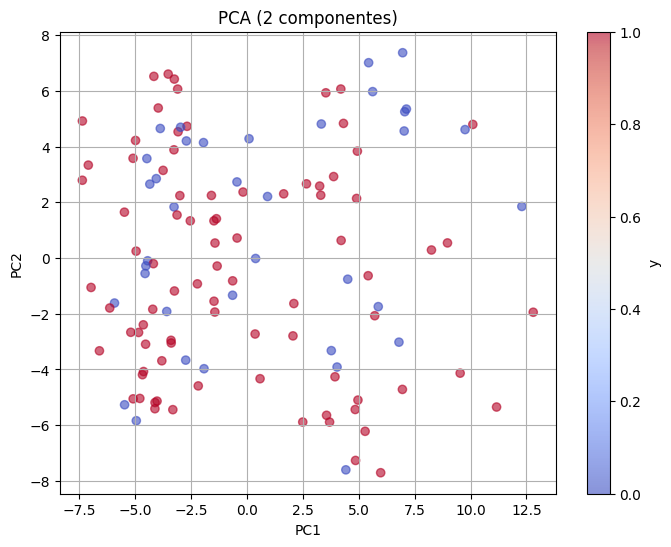

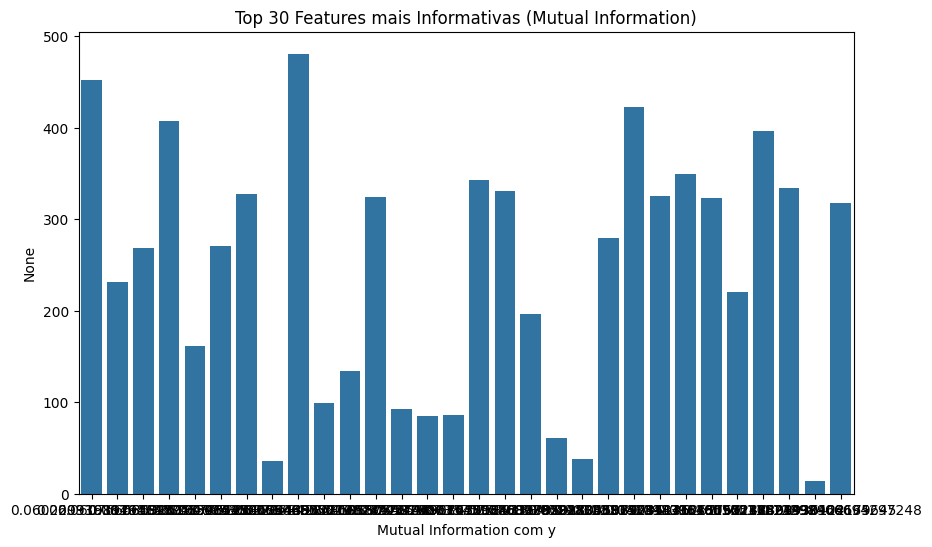

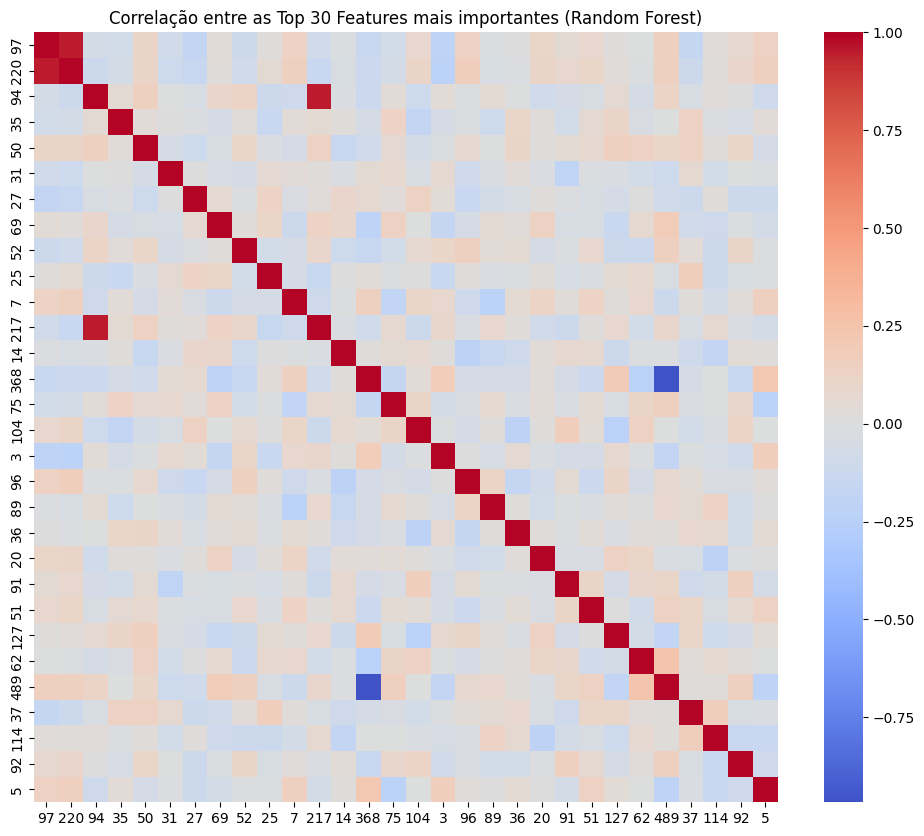

(242, 493) (242, 1)


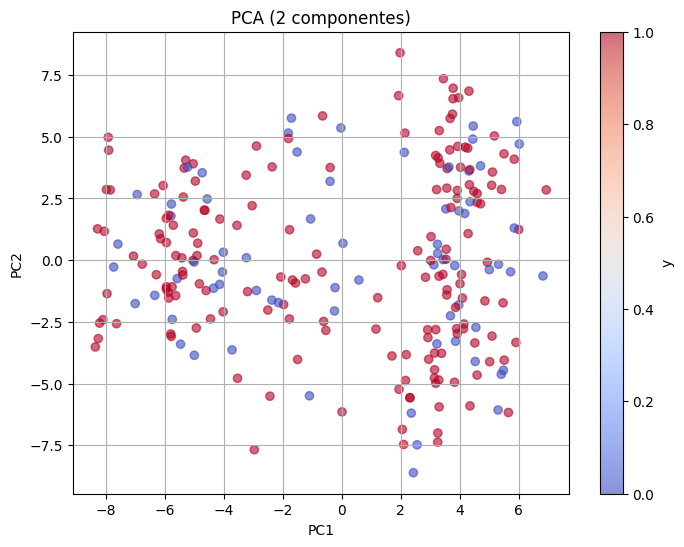

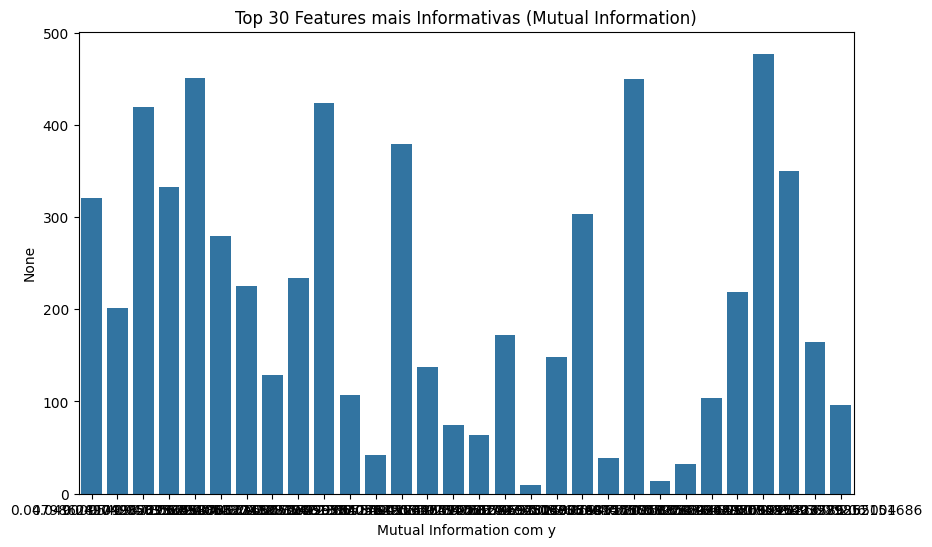

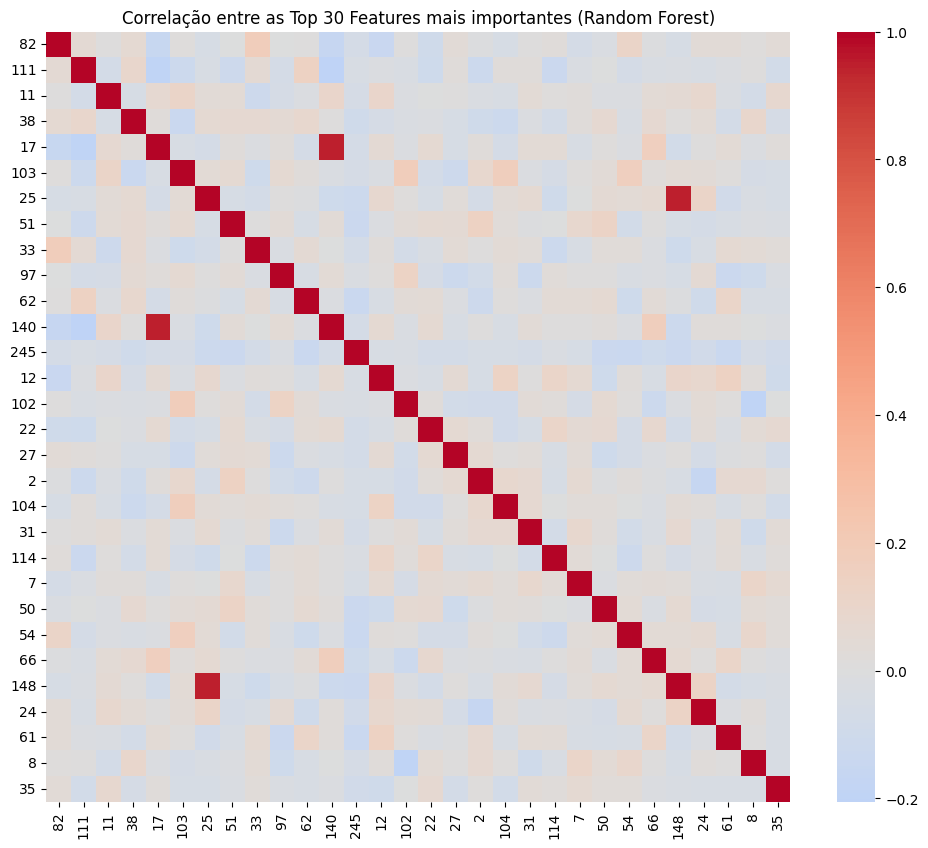

(362, 493) (362, 1)


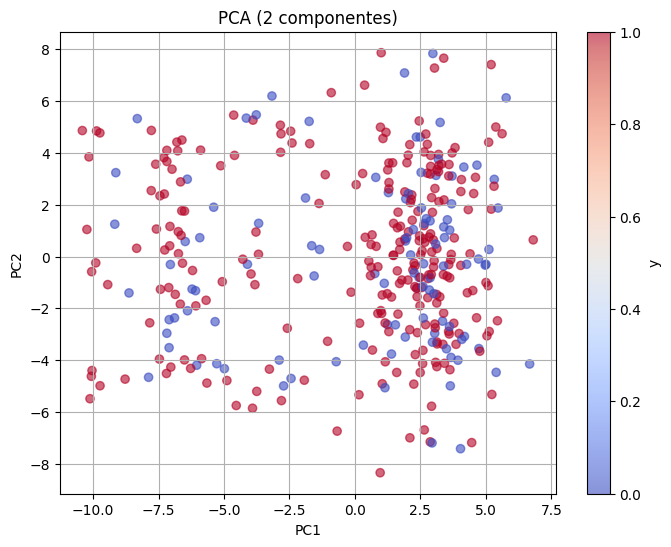

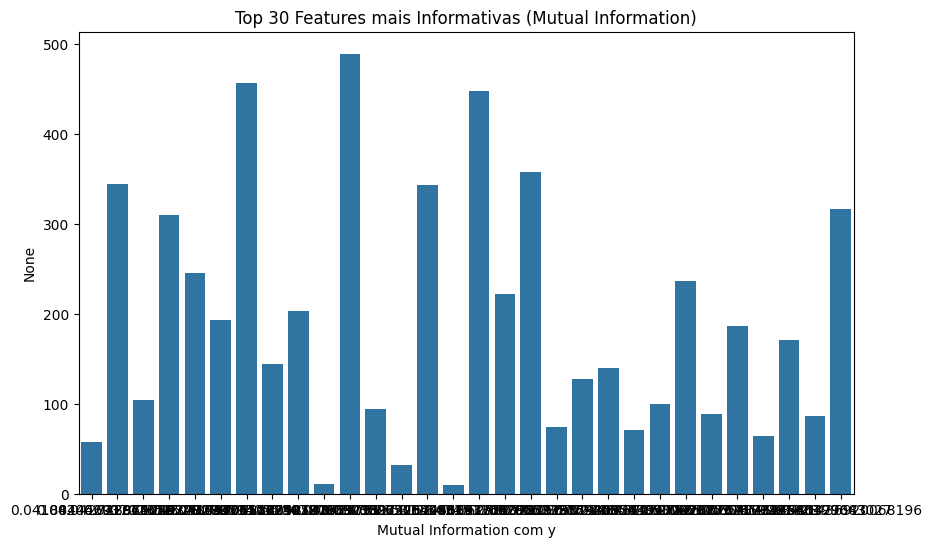

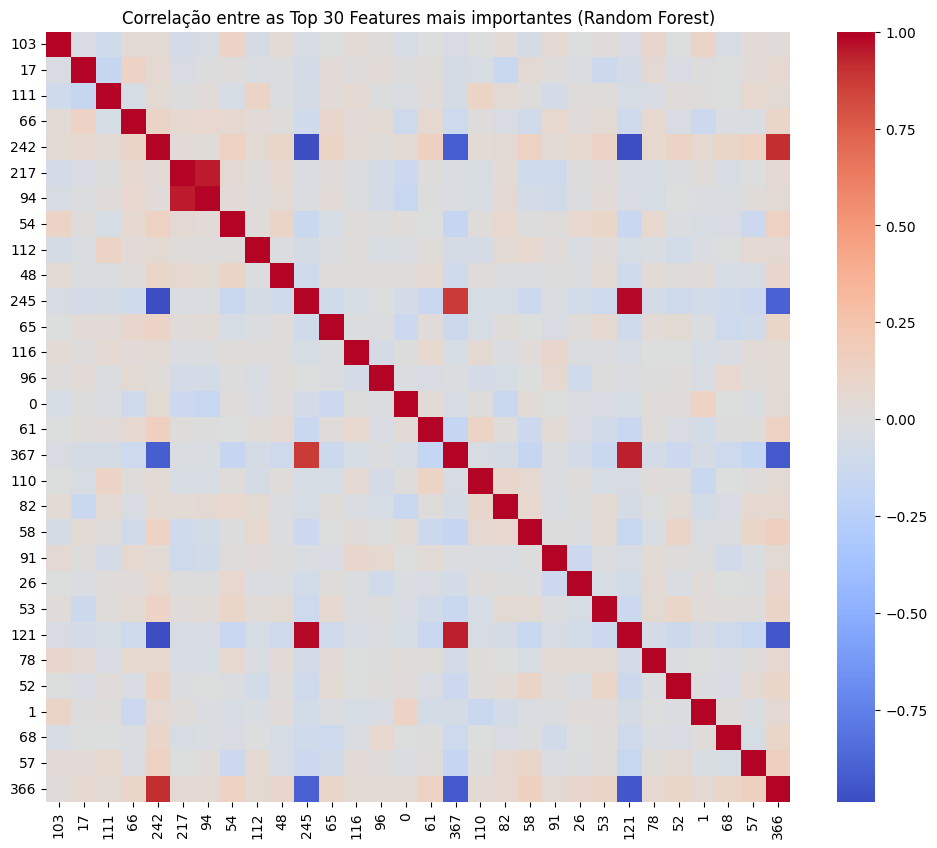

(482, 493) (482, 1)


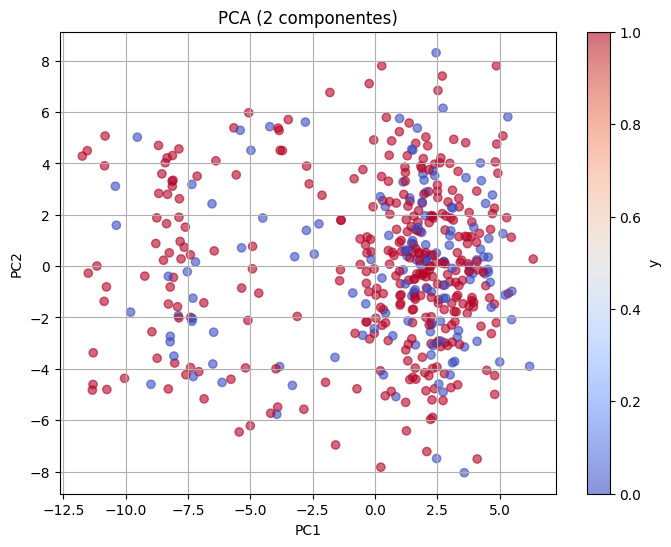

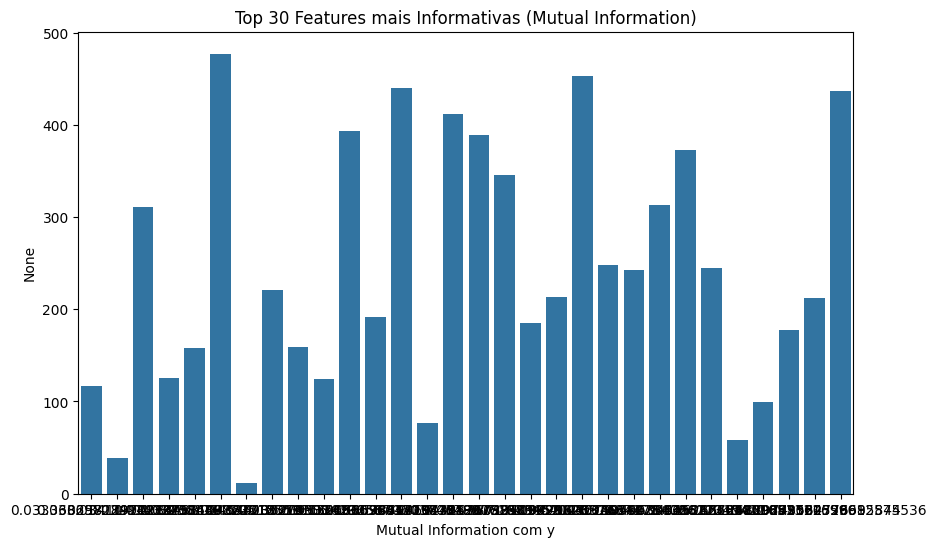

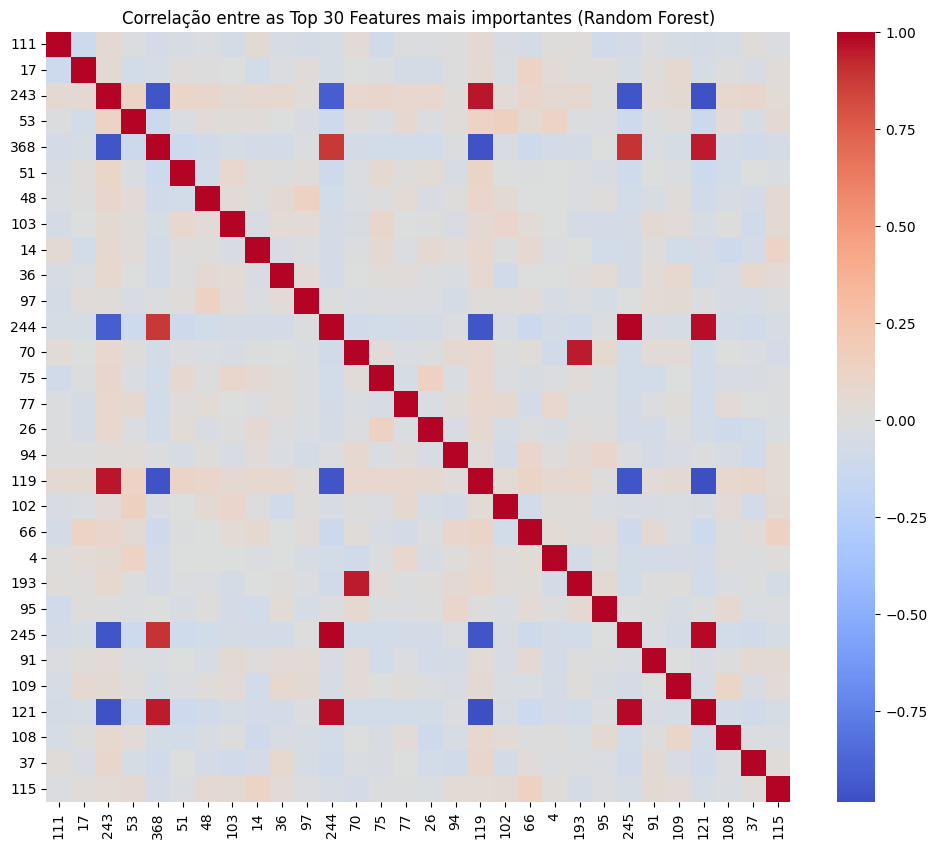

In [5]:
array = []
vetor = AjustesOdds(array)
for i in range(0, 720):
    array_ajuste, odd = vetor.coletarodd(i, 720, data)
    if i >= 240 and (i % 120 == 0):
        matriz1, matriz2 = vetor.tranforsmar_final_matriz(array_ajuste)
        print(matriz1.shape, matriz2.shape)
        # Etapa 1: Preparação
        X = pd.DataFrame(matriz1)
        y = matriz2.flatten()

        # Etapa 2: Correlação das features com y (usando Mutual Information)
        mi = mutual_info_classif(X, y, discrete_features='auto')
        mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

        # Etapa 3: Importância via Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)
        importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

        # Etapa 4: Correlação entre as próprias features (matriz de correlação)
        corr_matrix = X.corr()

        # Etapa 5: Redução de dimensionalidade via PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)

        # Plot: 2D PCA
        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
        plt.title('PCA (2 componentes)')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.colorbar(label='y')
        plt.grid(True)
        plt.show()

        # Plot: Heatmap das top 30 correlações com y
        top_mi = mi_series.head(30)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_mi.values, y=top_mi.index)
        plt.title('Top 30 Features mais Informativas (Mutual Information)')
        plt.xlabel('Mutual Information com y')
        plt.show()

        # Plot: Heatmap de correlação entre features (top 30 mais importantes por RF)
        top_rf = importances.head(30).index
        plt.figure(figsize=(12, 10))
        sns.heatmap(X[top_rf].corr(), annot=False, cmap='coolwarm', center=0)
        plt.title('Correlação entre as Top 30 Features mais importantes (Random Forest)')
        plt.show()


In [6]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

(122, 493) (122, 1)
Modelo Linear - Regressão Logística
              precision    recall  f1-score   support

           0       0.30      0.43      0.35         7
           1       0.73      0.61      0.67        18

    accuracy                           0.56        25
   macro avg       0.52      0.52      0.51        25
weighted avg       0.61      0.56      0.58        25

Modelo Não Linear - Random Forest


/home/darkcover1/Documentos/Work/Out/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover1/Documentos/Work/Out/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover1/Documentos/Work/Out/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.72      1.00      0.84        18

    accuracy                           0.72        25
   macro avg       0.36      0.50      0.42        25
weighted avg       0.52      0.72      0.60        25



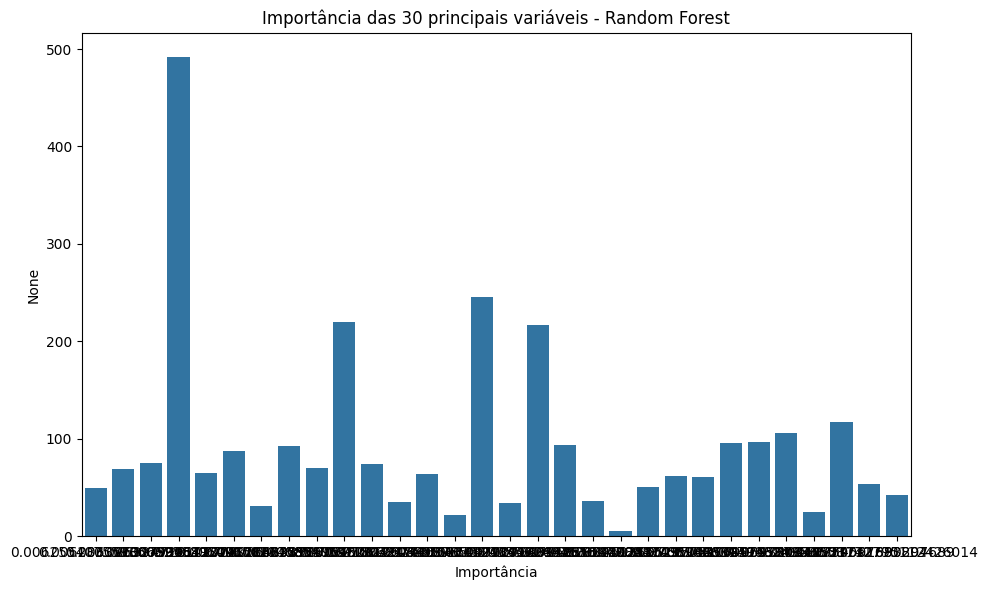

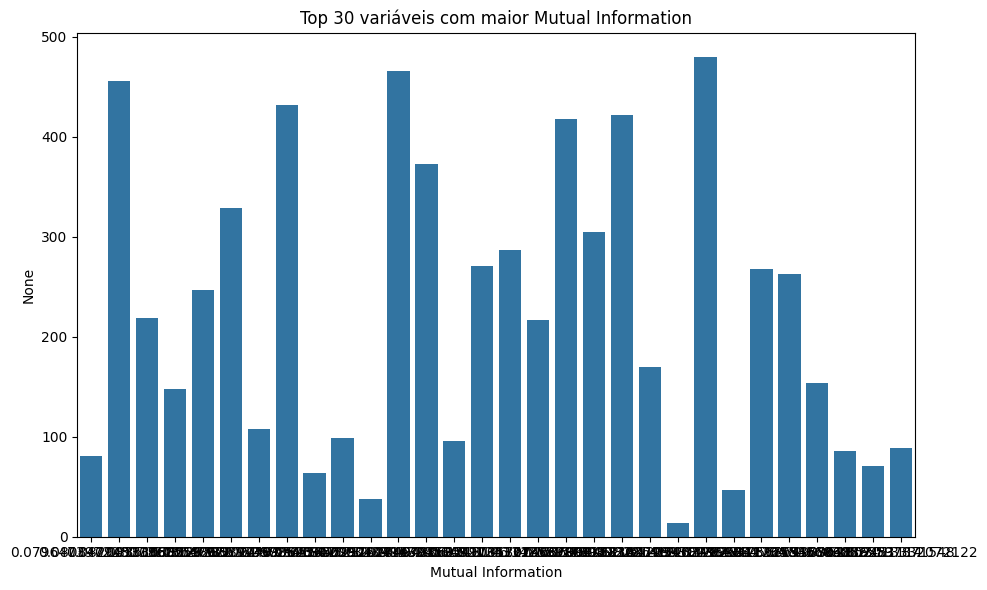

(242, 493) (242, 1)
Modelo Linear - Regressão Logística
              precision    recall  f1-score   support

           0       0.33      0.27      0.30        15
           1       0.70      0.76      0.73        34

    accuracy                           0.61        49
   macro avg       0.52      0.52      0.51        49
weighted avg       0.59      0.61      0.60        49

Modelo Não Linear - Random Forest
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.69      1.00      0.82        34

    accuracy                           0.69        49
   macro avg       0.35      0.50      0.41        49
weighted avg       0.48      0.69      0.57        49



/home/darkcover1/Documentos/Work/Out/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover1/Documentos/Work/Out/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover1/Documentos/Work/Out/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

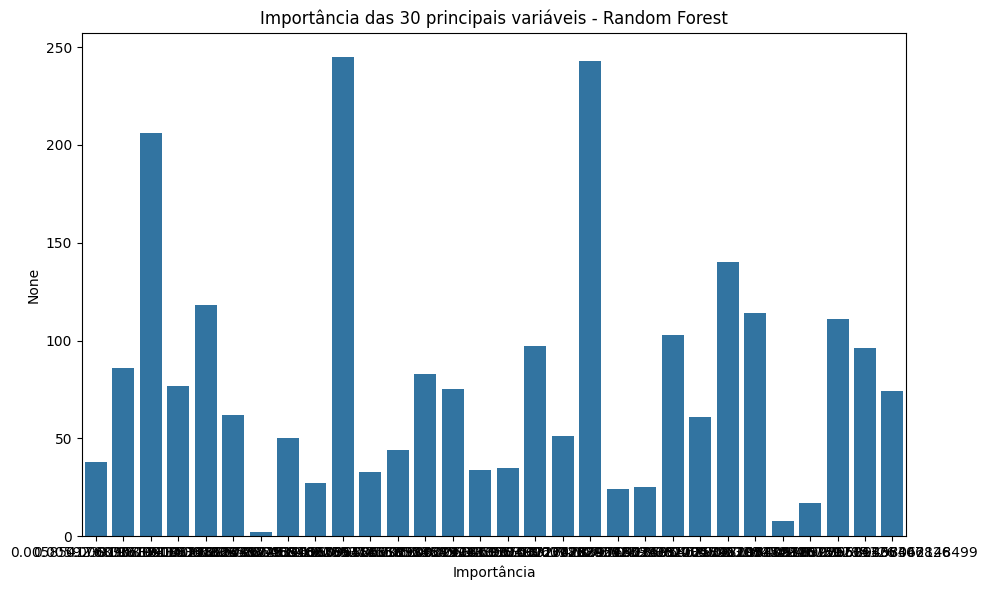

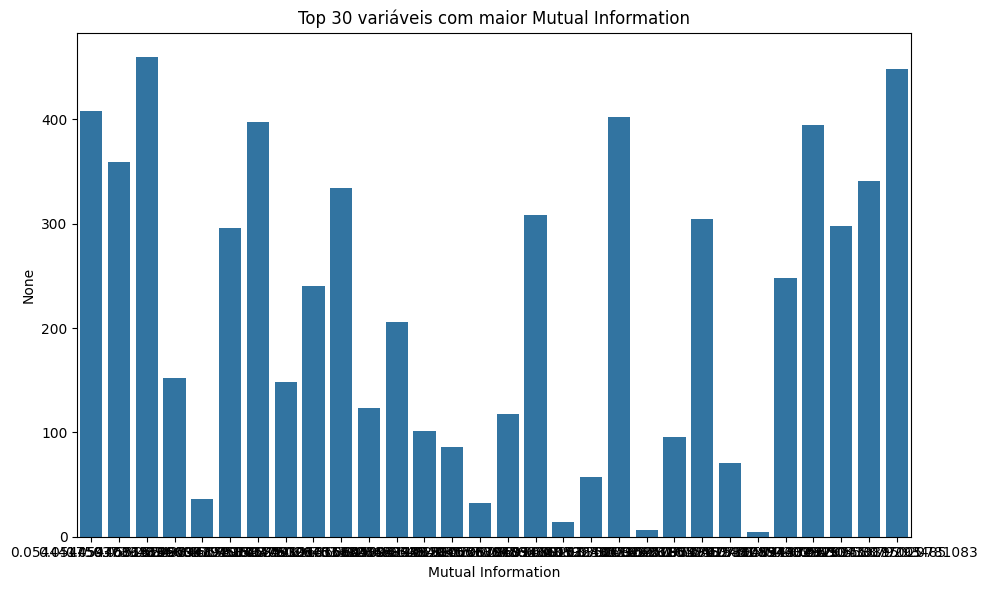

(362, 493) (362, 1)
Modelo Linear - Regressão Logística
              precision    recall  f1-score   support

           0       0.21      0.22      0.22        18
           1       0.74      0.73      0.73        55

    accuracy                           0.60        73
   macro avg       0.48      0.47      0.48        73
weighted avg       0.61      0.60      0.61        73

Modelo Não Linear - Random Forest
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.75      1.00      0.86        55

    accuracy                           0.75        73
   macro avg       0.38      0.50      0.43        73
weighted avg       0.57      0.75      0.65        73



/home/darkcover1/Documentos/Work/Out/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover1/Documentos/Work/Out/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover1/Documentos/Work/Out/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

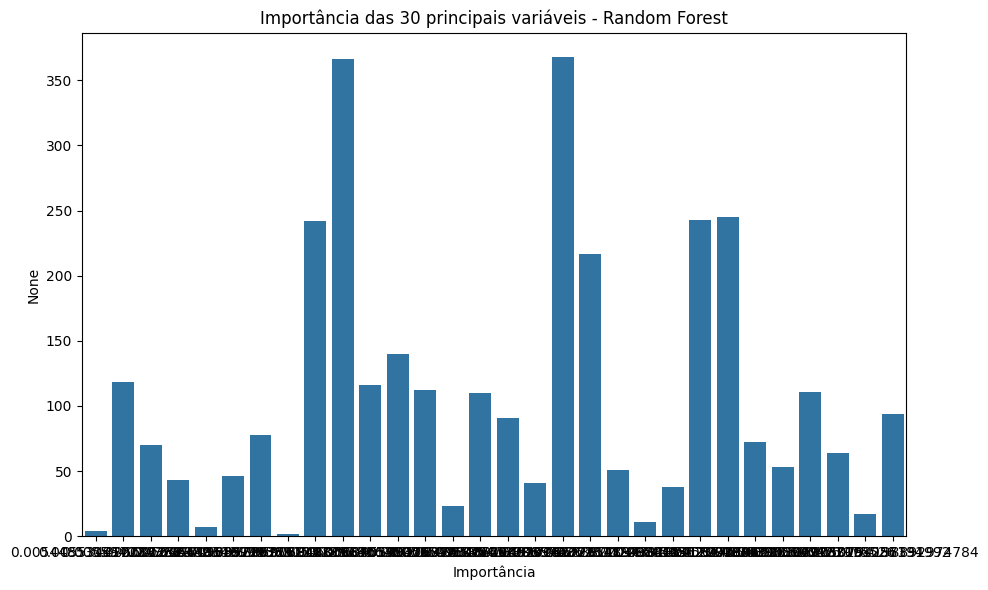

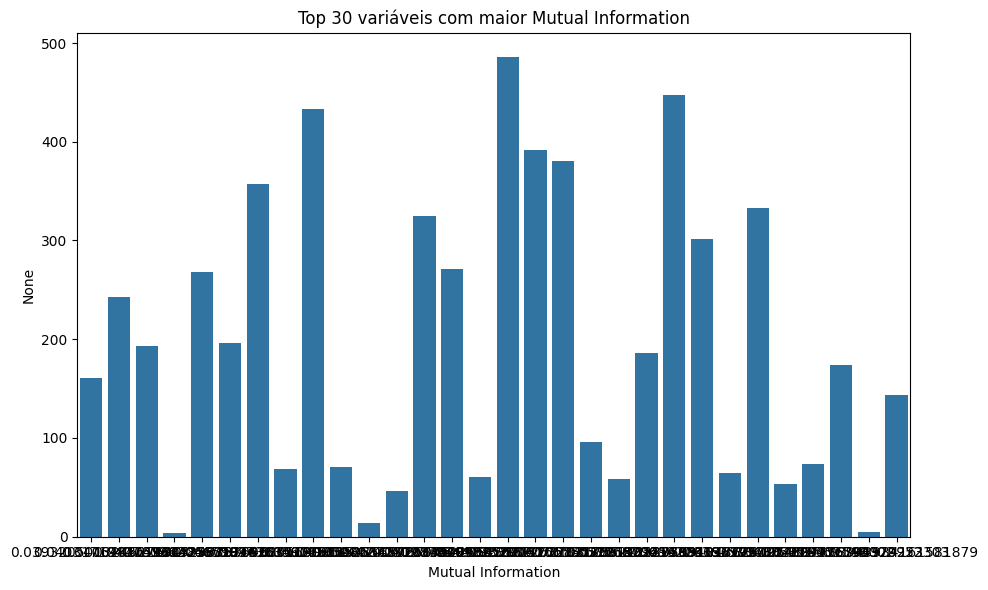

(482, 493) (482, 1)
Modelo Linear - Regressão Logística
              precision    recall  f1-score   support

           0       0.30      0.30      0.30        33
           1       0.64      0.64      0.64        64

    accuracy                           0.53        97
   macro avg       0.47      0.47      0.47        97
weighted avg       0.53      0.53      0.53        97

Modelo Não Linear - Random Forest
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.66      1.00      0.80        64

    accuracy                           0.66        97
   macro avg       0.33      0.50      0.40        97
weighted avg       0.44      0.66      0.52        97



/home/darkcover1/Documentos/Work/Out/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover1/Documentos/Work/Out/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover1/Documentos/Work/Out/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

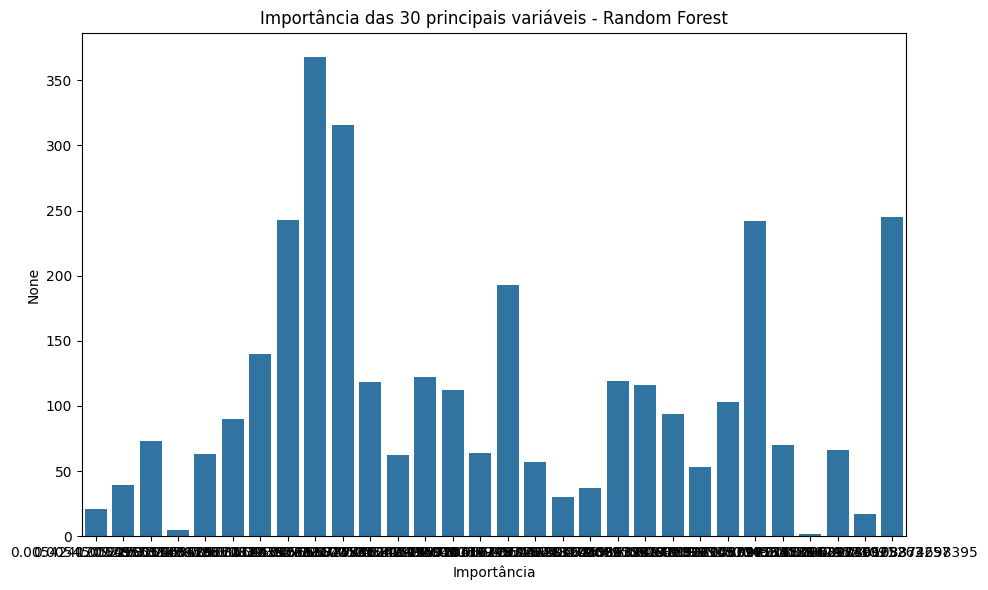

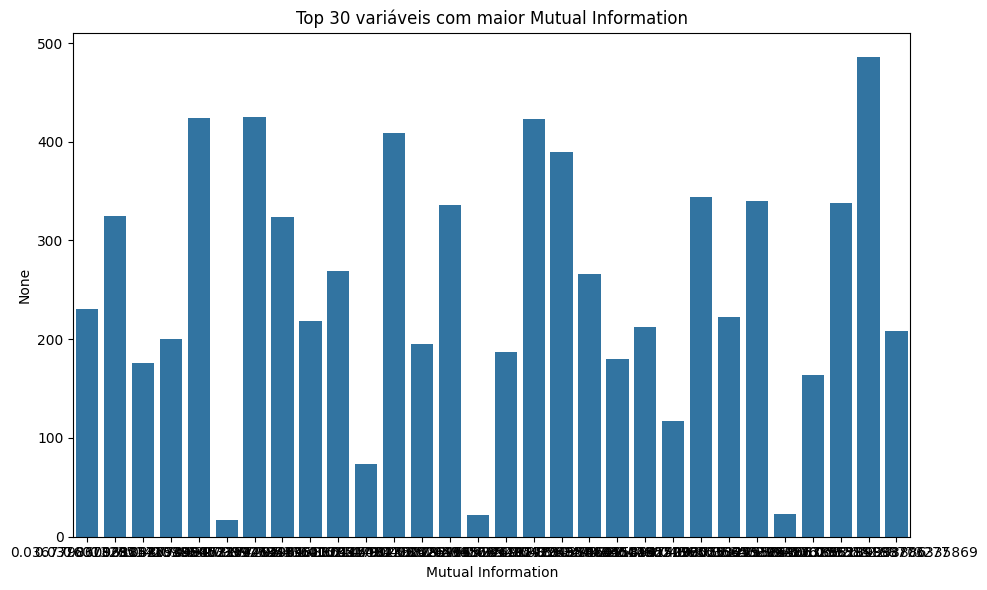

In [7]:
array = []
vetor = AjustesOdds(array)
for i in range(0, 720):
    array_ajuste, odd = vetor.coletarodd(i, 720, data)
    if i >= 240 and (i % 120 == 0):
        matriz1, matriz2 = vetor.tranforsmar_final_matriz(array_ajuste)
        print(matriz1.shape, matriz2.shape)

        # 1. Pré-processamento
        # Supondo que você já tenha X_final (matriz com shape [n_amostras, n_features]) e y_final (vetor binário)

        X = pd.DataFrame(matriz1)  # suas features
        y = matriz2.flatten()      # saída binária

        # 2. Divisão treino/teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 3. Modelo linear base (regressão logística)
        logreg = LogisticRegression(max_iter=1000)
        logreg.fit(X_train, y_train)
        y_pred_lr = logreg.predict(X_test)

        print("Modelo Linear - Regressão Logística")
        print(classification_report(y_test, y_pred_lr))

        # 4. Modelo não linear (Random Forest)
        rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)

        print("Modelo Não Linear - Random Forest")
        print(classification_report(y_test, y_pred_rf))

        # 5. Importância das features via Random Forest
        importances = pd.Series(rf.feature_importances_, index=X.columns)
        top_features = importances.sort_values(ascending=False).head(30)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_features.values, y=top_features.index)
        plt.title("Importância das 30 principais variáveis - Random Forest")
        plt.xlabel("Importância")
        plt.tight_layout()
        plt.show()

        # 6. Mutual Information
        mi = mutual_info_classif(X_train, y_train)
        mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False).head(30)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=mi_series.values, y=mi_series.index)
        plt.title("Top 30 variáveis com maior Mutual Information")
        plt.xlabel("Mutual Information")
        plt.tight_layout()
        plt.show()
